In [1]:
import numpy as np
import dolfin as dl


class FenicsFunctionToRegularGridInterpolator:
    # https://github.com/NickAlger/helper_functions/blob/master/fenics_function_to_regular_grid_interpolator.ipynb
    def __init__(me, function_space_V):
        me.V = function_space_V
        mesh = me.V.mesh()
        me.d = mesh.geometric_dimension()
        me.bbt = mesh.bounding_box_tree()
        pt_outside_mesh = dl.Point(np.inf * np.ones(mesh.geometric_dimension()))
        me.bad_bbt_entity = me.bbt.compute_first_entity_collision(pt_outside_mesh)

    def point_is_in_mesh(me, p_numpy):
        p_fenics = dl.Point(p_numpy)
        if me.bbt.compute_first_entity_collision(p_fenics) == me.bad_bbt_entity:
            return False
        else:
            return True

    def interpolate(me, u_fenics, grid_min, grid_max, grid_shape, 
                    outside_domain_default_value=0.0, use_extrapolation=False):
        if use_extrapolation:
            u_fenics.set_allow_extrapolation(True)
        
        all_XX = make_regular_grid(grid_min, grid_max, grid_shape)
        
        U = np.zeros(grid_shape)
        for ii in range(np.prod(grid_shape)):
            nd_ind = np.unravel_index(ii, grid_shape)
            p = np.array([all_XX[k][nd_ind] for k in range(me.d)])
            
            if use_extrapolation:
                U[nd_ind] = u_fenics(dl.Point(p))
                
            elif me.point_is_in_mesh(p):
                U[nd_ind] = u_fenics(dl.Point(p))
                
            else:
                U[nd_ind] = outside_domain_default_value
            
        return U

    def interpolate_within_ellipsoid(me, u_fenics, grid_min, grid_max, grid_shape,
                                     mu, Sigma, tau, 
                                     outside_domain_default_value=0.0, 
                                     inside_domain_default_value=0.0, 
                                     use_extrapolation=False):
        if use_extrapolation:
            u_fenics.set_allow_extrapolation(True)
            
        all_XX = make_regular_grid(grid_min, grid_max, grid_shape)
        
        U = np.zeros(grid_shape)
        for ii in range(np.prod(grid_shape)):
            nd_ind = np.unravel_index(ii, grid_shape)
            p = np.array([all_XX[k][nd_ind] for k in range(me.d)])
            
            if me.point_is_in_mesh(p):                
                if point_is_in_ellipsoid(p, mu, Sigma, tau): # inside mesh, inside ellipsoid
                    U[nd_ind] = u_fenics(dl.Point(p))
                else: # inside mesh, outside ellipsoid
                    U[nd_ind] = inside_domain_default_value
            
            elif (not point_is_in_ellipsoid(p, mu, Sigma, tau)): # outside mesh, outside ellipsoid
                U[nd_ind] = outside_domain_default_value
                
            else: # outside mesh, inside ellipsoid
                if use_extrapolation:
                    U[nd_ind] = u_fenics(dl.Point(p))
                else:
                    U[nd_ind] = outside_domain_default_value
                
        return U

def make_regular_grid(grid_min, grid_max, grid_shape):
    all_xx = (np.linspace(grid_min[k], grid_max[k], grid_shape[k]) for k in range(grid_min.shape[0]))
    all_XX = np.meshgrid(*all_xx, indexing='ij')
    return all_XX
    
def point_is_in_ellipsoid(p, mu, Sigma, tau):
    d = (mu - p).reshape(-1)
    return np.dot(d, np.linalg.solve(Sigma, d)) <= tau**2

# Test

In [2]:
import mshr
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.patches as patches

def plot_ellipse(mu, Sigma, n_std_tau):
    ee, V = np.linalg.eigh(Sigma)
    e_big = ee[1]
    e_small = ee[0]
    v_big = V[:, 1]
    theta = np.arctan(v_big[1] / v_big[0]) * 180. / np.pi

    long_length = n_std_tau * 2. * np.sqrt(e_big)
    short_length = n_std_tau * 2. * np.sqrt(e_small)

    ellipse = Ellipse(mu, width=long_length, height=short_length, angle=theta, facecolor='none', edgecolor='k')
    plt.gca().add_artist(ellipse)
    
def plot_rectangle(minpt, maxpt, edgecolor='k'):
    delta = maxpt - minpt
    rect = patches.Rectangle(minpt, delta[0], delta[1], linewidth=1, edgecolor=edgecolor, facecolor='none')
    plt.gca().add_patch(rect)

def circle_mesh(center, radius, resolution):
    outer_circle = mshr.Circle(dl.Point(center[0], center[1]), radius)
    mesh = mshr.generate_mesh(outer_circle, resolution)
    return mesh

def compute_ellipsoid_bounding_box(mu, Sigma, tau):
    # Ellipse: (x-mu)^T Sigma^-1 (x-mu) < tau^2
    widths = np.sqrt(Sigma.diagonal()) * tau
    min_pt = mu - widths
    max_pt = mu + widths
    return min_pt, max_pt

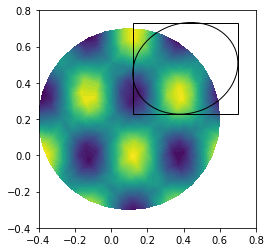

In [3]:
mesh = circle_mesh(np.array([0.1,0.2]), 0.5, 10)

mu = np.array([0.41, 0.48])
Sigma = np.array([[2.1, 0.2],
                  [0.2, 1.6]])*0.01
tau = 2.0

grid_min, grid_max = compute_ellipsoid_bounding_box(mu, Sigma, tau)
grid_shape = np.array([20,25])

V = dl.FunctionSpace(mesh, 'CG', 2)
u_expr = dl.Expression('sin(4*pi*x[0])*cos(3*pi*x[1])', domain=mesh, degree=5)
u = dl.interpolate(u_expr, V)

fig = plt.figure()
ax = fig.add_subplot(111)
dl.plot(u)
plot_ellipse(mu, Sigma, tau)
plot_rectangle(grid_min, grid_max)
plt.xlim(-0.4, 0.8)
plt.ylim(-0.4, 0.8)
plt.show()

Text(0.5, 1.0, 'ellipse truncation with extrapolation')

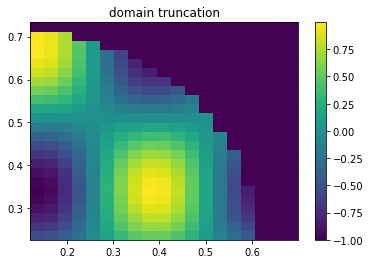

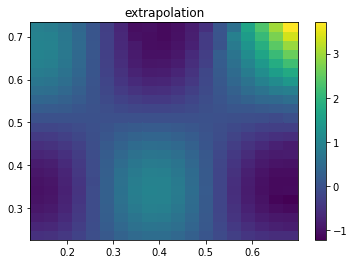

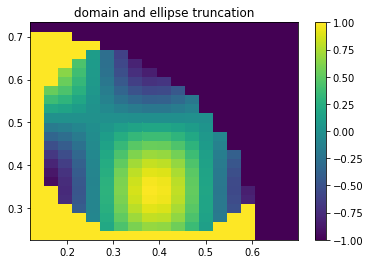

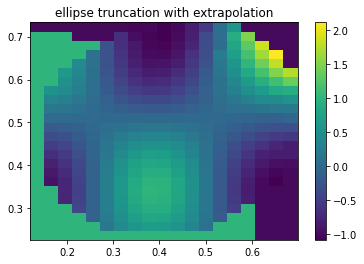

In [4]:
V_grid_interpolator = FenicsFunctionToRegularGridInterpolator(V)

X, Y = make_regular_grid(grid_min, grid_max, grid_shape)

U1 = V_grid_interpolator.interpolate(u, grid_min, grid_max, grid_shape, outside_domain_default_value=-1.0)

plt.figure()
plt.pcolor(X,Y,U1)
plt.colorbar()
plt.title('domain truncation')

U2 = V_grid_interpolator.interpolate(u, grid_min, grid_max, grid_shape, use_extrapolation=True)

plt.figure()
plt.pcolor(X,Y,U2)
plt.colorbar()
plt.title('extrapolation')

U3 = V_grid_interpolator.interpolate_within_ellipsoid(u, grid_min, grid_max, grid_shape, mu, Sigma, tau, 
                                                      outside_domain_default_value=-1.0, 
                                                      inside_domain_default_value=1.0)

plt.figure()
plt.pcolor(X,Y,U3)
plt.colorbar()
plt.title('domain and ellipse truncation')

U4 = V_grid_interpolator.interpolate_within_ellipsoid(u, grid_min, grid_max, grid_shape, mu, Sigma, tau, 
                                                      outside_domain_default_value=-1.0, 
                                                      inside_domain_default_value=1.0,
                                                      use_extrapolation=True)

plt.figure()
plt.pcolor(X,Y,U4)
plt.colorbar()
plt.title('ellipse truncation with extrapolation')